In [14]:
!pip install scikit-build
!pip install pyikarus  --no-build-isolation --verbose --upgrade


Using pip 23.0.1 from /dune/dune-common/build-cmake/dune-env/lib/python3.10/site-packages/pip (python 3.10)


### Import all packages

In [15]:
import matplotlib
import dune.grid
import dune.functions
import pyikarus as iks
import pyikarus.finite_elements
import pyikarus.utils
import pyikarus.assembler
import pyikarus.dirichletValues
import numpy as np
import scipy as sp
from dune.vtk import  vtkWriter


### Create grid

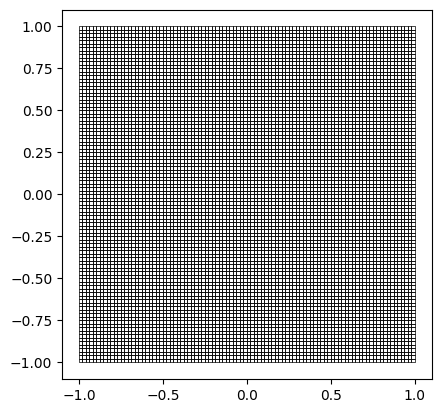

In [16]:
lowerLeft = [-1,-1]
upperRight = [1,1]
elements = [3,3]

grid = dune.grid.structuredGrid(lowerLeft,upperRight,elements)
grid.hierarchicalGrid.globalRefine(5)
grid.plot()

### Add Lagrangian basis

In [17]:
basisLagrange1 = dune.functions.defaultGlobalBasis(grid, dune.functions.Power(dune.functions.Lagrange(order=1),2))
print('We have {} dofs.'.format(len(basisLagrange1)))
print('We have {} vertices.'.format(grid.size(2)))
print('We have {} elements.'.format(grid.size(0)))

We have 18818 dofs.
We have 9409 vertices.
We have 9216 elements.


### Init load factor and displacement vector

In [18]:
d = np.zeros(len(basisLagrange1))
lambdaLoad = iks.ValueWrapper(3.0)

### Create finite element requirements

In [19]:
req= iks.FErequirements()
req.addAffordance(iks.ScalarAffordances.mechanicalPotentialEnergy)
req.addAffordance(iks.VectorAffordances.forces)
req.addAffordance(iks.MatrixAffordances.stiffness)

req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
req.insertGlobalSolution(iks.FESolutions.displacement,d)

### Define volume load and boundary loads

In [20]:
def volumeLoad(x,lambdaVal) :
    return np.array([lambdaVal*x[0]*2*0, 2*lambdaVal*x[1]*0])

def neumannLoad(x,lambdaVal) :
    return np.array([lambdaVal*100, lambdaVal])

neumannVertices = np.zeros(grid.size(2)*2, dtype=bool)
basisLagrange1.interpolate(neumannVertices, lambda x :  True  if x[1]==1 else False)

boundaryPatch = iks.utils.boundaryPatch(grid,neumannVertices)

### Create vector of finite elements

In [21]:
fes = []
for e in grid.elements:
    #print(e.geometry.center)
    fe = iks.finite_elements.linearElasticElement(basisLagrange1,e,1000,0.2,volumeLoad,boundaryPatch,neumannLoad)
    print(id(fe))  
    fes.append(fe)
print("test")
print(id(fes[0]))    
print(id(fes[1]))    
print(id(fes[2])) 
print(id(fes[3])) 
print(id(fes[4])) 
print(id(fes[5])) 
print(id(fes[6])) 
print(id(fes[7])) 
print(id(fes[8])) 

139715771684656
139715865424432
139715866039280
139717073709488
139715772236464
139715772236080
139715772237040
139715772237168
139715772237616
139715772236592
139715772237936
139715772238384
139715772238512
139715772238960
139715772239088
139715772239536
139715772239664
139715772240112
139715772240240
139715772240688
139715772240816
139715772241264
139715772241392
139715772241840
139715772241968
139715772242416
139715772242544
139715772242992
139715772243120
139715772243568
139715772243696
139715772244144
139715772244272
139715772244720
139715772244848
139715772245296
139715772245424
139715772245872
139715772246000
139715772246448
139715772246576
139715772247024
139715772247152
139715772247600
139715772247728
139715772248176
139715772248304
139715772248752
139715772248880
139715772249328
139715772249456
139715772249904
139715772250032
139715772250480
139715772250608
139715772251056
139715772251184
139715772251632
139715772251760
139715772252080
139715772236912
139715772237296
13971577

### print forces and stiffness of first element

In [22]:
forces = np.zeros(8)
stiffness = np.zeros((8,8))
fes[1].calculateVector(req,forces)
fes[1].calculateMatrix(req,stiffness)
np.set_printoptions(precision=3)
print('Forces:\n {}'.format(forces))
print('Stiffness:\n {}'.format(stiffness))

Forces:
 [0. 0. 0. 0. 0. 0. 0. 0.]
Stiffness:
 [[ 486.111  156.25  -277.778  -52.083   34.722   52.083 -243.056 -156.25 ]
 [ 156.25   486.111   52.083   34.722  -52.083 -277.778 -156.25  -243.056]
 [-277.778   52.083  486.111 -156.25  -243.056  156.25    34.722  -52.083]
 [ -52.083   34.722 -156.25   486.111  156.25  -243.056   52.083 -277.778]
 [  34.722  -52.083 -243.056  156.25   486.111 -156.25  -277.778   52.083]
 [  52.083 -277.778  156.25  -243.056 -156.25   486.111  -52.083   34.722]
 [-243.056 -156.25    34.722   52.083 -277.778  -52.083  486.111  156.25 ]
 [-156.25  -243.056  -52.083 -277.778   52.083   34.722  156.25   486.111]]


### Create Dirichlet boundary conditions

In [23]:
dirichletValues = iks.dirichletValues(basisLagrange1) 

def fixBottomEdge(vec,localIndex,localView,intersection):
    if (intersection.geometry.center[1]==-1):
        vec[localView.index(localIndex)]= True

dirichletValues.fixBoundaryDOFsUsingLocalViewAndIntersection(fixBottomEdge)

### Create assembler

In [24]:
assembler = iks.assembler.sparseFlatAssembler(fes,dirichletValues)
#assemblerDense = iks.assembler.denseFlatAssembler(fes,dirichletValues)

Msparse = assembler.getMatrix(req)
forces = assembler.getVector(req)
#print(Msparse)
#print(forces)

### Solve for displacements and write to paraview

In [25]:
d = sp.sparse.linalg.spsolve(Msparse,-forces)
dispFunc = basisLagrange1.asFunction(d)

writer = vtkWriter( grid, "nameTest",  pointData   = {( "displacement",(0,1)):dispFunc})

### Plot here using matplot lib

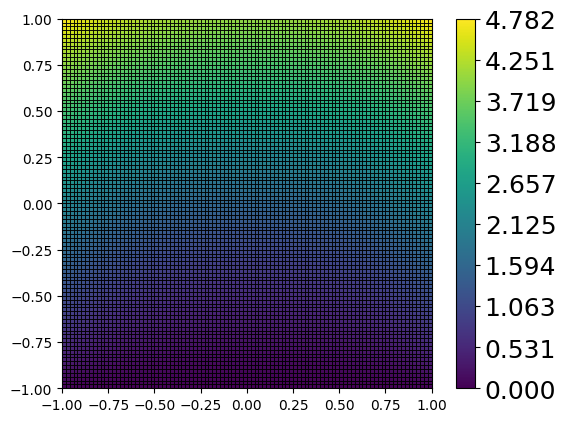

In [26]:
import dune.plotting
dune.plotting.plot(solution=dispFunc)